In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output

In [3]:
batch_size = 64
buffer_size = 1000
img_height = 240
img_width = 240

In [4]:
data_dir = os.path.join('data','mri-datasets','first-20-testset','slice_segmentation', 'train')
train_image_dir = os.path.join(data_dir,'image_data')
train_map_dir = os.path.join(data_dir,'map_data')



In [5]:
train_image_filenames = os.listdir(train_image_dir)
train_map_filenames = [filename.replace('allseq', 'map') for filename in train_image_filenames]
train_image_filepaths = [os.path.join(train_image_dir,filename) for filename in train_image_filenames]
train_map_filepaths = [os.path.join(train_map_dir,filename) for filename in train_map_filenames]


In [6]:
train_image_data = tf.data.Dataset.list_files(train_image_filepaths, shuffle=False)
train_map_data = tf.data.Dataset.list_files(train_map_filepaths, shuffle=False)
train_data = tf.data.Dataset.zip((train_image_data, train_map_data))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-02 13:42:36.850493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 13:42:36.850603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def alter_segmap(x):
    return tf.where(x==4,tf.constant(3,dtype='uint8'),x)

def read_image_map(image, seg_map):
   image = tf.io.read_file(image)
   image = tf.io.decode_png(image, channels=4)
   seg_map = tf.io.read_file(seg_map)
   seg_map = tf.io.decode_png(seg_map, channels=1)
   return scaler_neg1_1(tf.cast(image, 'float32')) ,alter_segmap(seg_map)



In [8]:
train_batch = (
    train_data.cache()
    .shuffle(buffer_size)
    .map(read_image_map)
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [9]:
images, masks = next(iter(train_batch))

2022-12-02 13:42:37.077850: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 13:42:37.130642: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


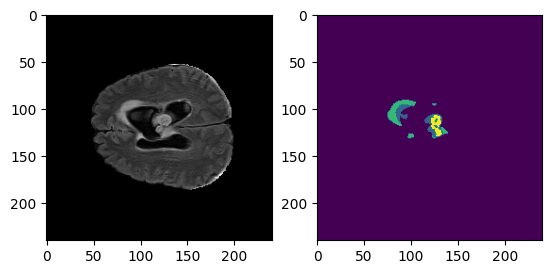

In [10]:
num = 5
fig, ax = plt.subplots(1,2)
ax[0].imshow(tf.cast(127.5*(images[num]+1)[:,:,3], 'uint8'), cmap='gist_gray')
ax[1].imshow(masks[num])